In [ ]:
#####################
## Ethereum (ETH)  ##
#####################

In [ ]:
!pip install tensorflow
!pip install numpy
!pip install pandas
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 5.1 MB/s eta 0:00:00


In [ ]:
#######################
###### Libraries ######
#######################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf

from hmmlearn.hmm import GaussianHMM
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.utils import to_categorical


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Set 3 seeds and record the model performance for each : 42, 45, 91
# Best seed 91
np.random.seed(91)
tf.random.set_seed(91)

In [ ]:
# Load dataset without scaling

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ETH_noscale.csv')
data.drop(columns=['Crypto', 'Open', 'High', 'Low'], inplace=True)
data.head()

,Date,Close
0,2018-01-01,757.01
1,2018-01-02,864.00
2,2018-01-03,938.00
3,2018-01-04,942.04
4,2018-01-05,958.00


In [ ]:
# -------------------------
# Step 1 - Normalisation
# -------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']].values.reshape(-1, 1))
input_data = scaled_data.reshape(-1)

# ---------------------------------
# Step 2 - Generate sliding windows
# ---------------------------------
train_end = int(0.65 * len(scaled_data)            ) # training ratio
val_end   = train_end + int(0.10 * len(scaled_data)) # validation ratio
window = 120                                         # window size - days of price input

train_slice = input_data[:train_end]
val_slice   = input_data[train_end:val_end]
test_slice  = input_data[val_end:]

def sequence(data, window_size):
    data = np.asarray(data).reshape(-1, 1)
    x, y = [], []
    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(x), np.array(y)

x_train, y_train = sequence(train_slice, window)
x_val,   y_val   = sequence(val_slice,   window)
x_test,  y_test  = sequence(test_slice,  window)


In [ ]:
# ---------------------------------
# Step 3 - Build Gaussian HMM
# ---------------------------------

# Fit Gaussian HMM with 3 states on the training input data
hmm = GaussianHMM(n_components=3, n_iter=200, random_state=42)
hmm.fit(train_slice.reshape(-1,1))

# Build train, val, test arrays with the last indices in each LSTM sequence (above)
# The aim is to align the HMM input data to the LSTM sequences of 120-day input
# To avoid data leakage (into the future)
window = 120
train_last_idx = np.arange(window-1, train_end-1)
val_last_idx   = np.arange(train_end + window-1, val_end-1)
test_last_idx  = np.arange(val_end   + window-1, len(input_data)-1)


# -----------------------------------------
# Step 5 — Compute posterior probabilities
# -----------------------------------------

# Build the Causal HMM with the input data and train/val/test indices from above
# The probability of the next point is only based on the past datapoints
# Compute the posterior probability for each price at time t+1 for input 0...t (t=window-1)
# The post_probability of each of the 3 states is returned for all 3 sets and ready for use in training the model
def causal_hmm(price_series, hmm, index):
    post_probabilities = np.zeros((len(index), hmm.n_components))
    for i, t in enumerate(index):
        post_probabilities[i] = hmm.predict_proba(price_series[:t+1].reshape(-1,1))[-1]  # last row = uses data ≤ t
    return post_probabilities

H_train = causal_hmm(input_data, hmm, train_last_idx)
H_val   = causal_hmm(input_data, hmm, val_last_idx)
H_test  = causal_hmm(input_data, hmm, test_last_idx)

# HMM output with 'relu' activation function
# Input = one probability for each of 3 states
hmm_input = Input(shape=(3,))
hmm_out   = Dense(64, activation='relu')(hmm_input


In [ ]:
# ------------
# Parameters
# ------------
n_timesteps = x_train.shape[1]
n_features  = x_train.shape[2]
dropout_rate = 0.33454307320167703


# --------------------------
# Step 5 — LSTM branch input
# --------------------------
# LSTM branch
lstm_input = Input(shape=(n_timesteps, n_features))
y = LSTM(64, return_sequences=True, activation='tanh')(lstm_input)
y = Dropout(dropout_rate)(y)
y = LSTM(8, return_sequences=True, activation='tanh')(y)
lstm_out = LSTM(4, return_sequences=False, activation='tanh')(y)


# -----------------------------
# Step 6 — Concatenate HMM/LSTM
# -----------------------------
combined = Concatenate()([lstm_out, hmm_out])
combined = Dense(64, activation='tanh')(combined)
output = Dense(1, activation='linear')(combined)


# ---------------------------------
# Step 7 — Compile Model/Regression
# ---------------------------------
model = Model(inputs=[lstm_input, hmm_input], outputs=output)
model.compile(loss='mean_squared_error',
              optimizer=RMSprop(learning_rate=0.0009717787126451334),
              metrics=['mae', RootMeanSquaredError(), 'mape'])

In [ ]:
# ---------------------------------
# Step 8 — Model Training
# ---------------------------------
history = model.fit([x_train, H_train], y_train,
                    epochs=150, batch_size=16,
                    shuffle=False,
                    validation_data=([x_val, H_val], y_val),
                    verbose=2)


Epoch 1/150
73/73 - 6s - 80ms/step - loss: 0.0099 - mae: 0.0653 - mape: 62242.9453 - root_mean_squared_error: 0.0996 - val_loss: 0.0980 - val_mae: 0.2972 - val_mape: 34.9745 - val_root_mean_squared_error: 0.3130
Epoch 2/150
73/73 - 1s - 16ms/step - loss: 0.0037 - mae: 0.0426 - mape: 722.0674 - root_mean_squared_error: 0.0607 - val_loss: 0.0425 - val_mae: 0.1839 - val_mape: 21.1442 - val_root_mean_squared_error: 0.2061
Epoch 3/150
73/73 - 1s - 16ms/step - loss: 0.0031 - mae: 0.0387 - mape: 5335.8491 - root_mean_squared_error: 0.0558 - val_loss: 0.0315 - val_mae: 0.1548 - val_mape: 17.7038 - val_root_mean_squared_error: 0.1775
Epoch 4/150
73/73 - 1s - 16ms/step - loss: 0.0028 - mae: 0.0364 - mape: 11077.7285 - root_mean_squared_error: 0.0529 - val_loss: 0.0281 - val_mae: 0.1455 - val_mape: 16.6398 - val_root_mean_squared_error: 0.1675
Epoch 5/150
73/73 - 1s - 16ms/step - loss: 0.0026 - mae: 0.0351 - mape: 8421.7158 - root_mean_squared_error: 0.0511 - val_loss: 0.0296 - val_mae: 0.1506 - 

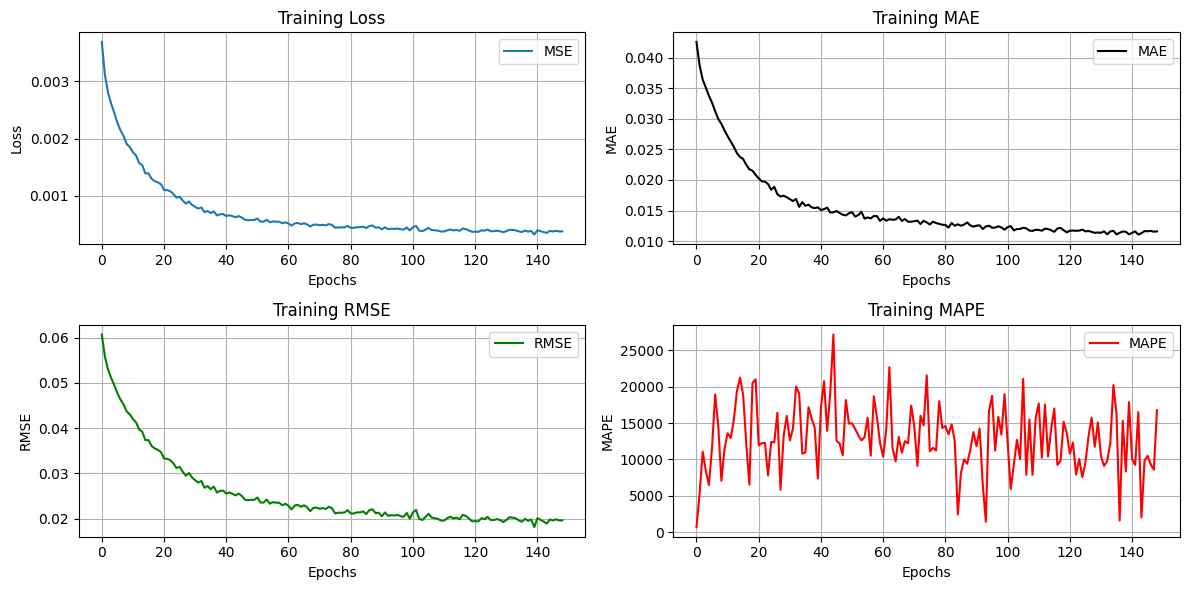

In [ ]:
####################
### Plot Results ###
####################

# Training MSE
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0, 0].plot(history.history['loss'][1:], label='MSE')
ax[0, 0].set_title('Training Loss')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].legend()
ax[0,0].grid(True)

# Training MAE
ax[0, 1].plot(history.history['mae'][1:], label='MAE', color='black')
ax[0, 1].set_title('Training MAE')
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('MAE')
ax[0, 1].legend()
ax[0,1].grid(True)

# Training RMSE
ax[1, 0].plot(history.history['root_mean_squared_error'][1:], label='RMSE', color='green')
ax[1, 0].set_title('Training RMSE')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('RMSE')
ax[1, 0].legend()
ax[1,0].grid(True)

# Training MAPE
ax[1, 1].plot(history.history['mape'][1:], label='MAPE', color='red')
ax[1, 1].set_title('Training MAPE')
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('MAPE')
ax[1, 1].legend()
ax[1,1].grid(True)

plt.tight_layout()
plt.show()

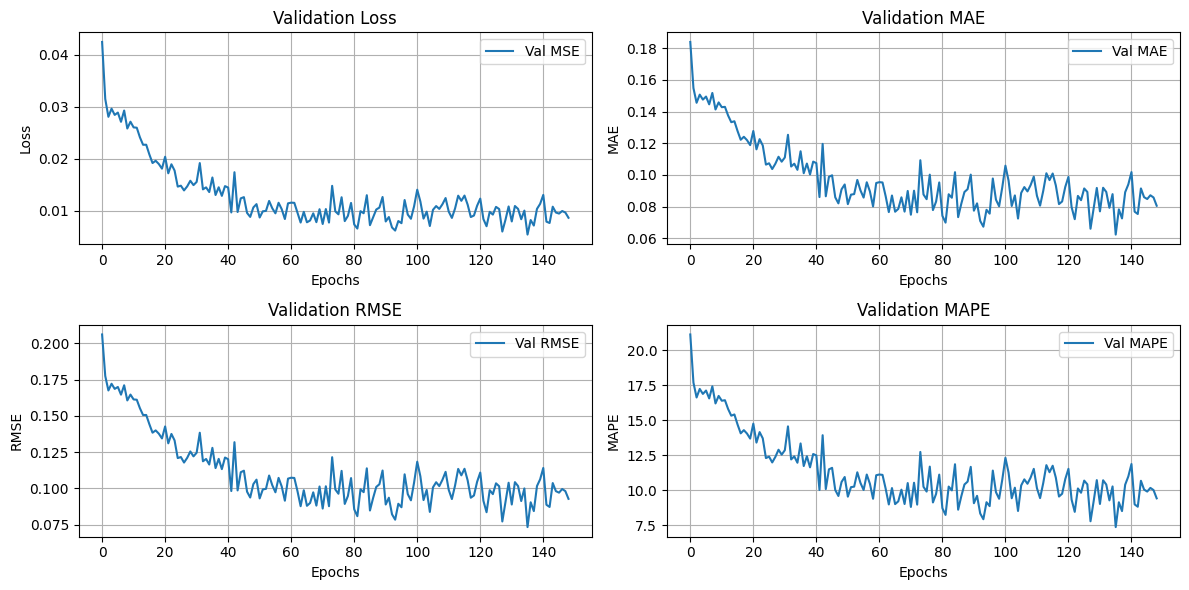

In [ ]:
# Validation MSE
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0, 0].plot(history.history['val_loss'][1:], label='Val MSE')
ax[0, 0].set_title('Validation Loss')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].legend()
ax[0,0].grid(True)

# Validation MAE
ax[0, 1].plot(history.history['val_mae'][1:], label='Val MAE')
ax[0, 1].set_title('Validation MAE')
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('MAE')
ax[0, 1].legend()
ax[0,1].grid(True)

# Validation RMSE
ax[1, 0].plot(history.history['val_root_mean_squared_error'][1:], label='Val RMSE')
ax[1, 0].set_title('Validation RMSE')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('RMSE')
ax[1, 0].legend()
ax[1,0].grid(True)


# Validation MAPE
ax[1, 1].plot(history.history['val_mape'][1:], label='Val MAPE')
ax[1, 1].set_title('Validation MAPE')
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('MAPE')
ax[1, 1].legend()
ax[1,1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Store best training/validation metrics
# Training
train_mse = history.history['loss']
best_epoch = np.argmin(train_mse)
best_train_mse = train_mse[best_epoch]
best_train_rmse = history.history['root_mean_squared_error'][best_epoch]
best_train_mae  = history.history['mae'][best_epoch]
best_train_mape = history.history['mape'][best_epoch]

# Validation: record epoch at which validation loss is the lowest for each seed
val_mse = history.history['val_loss']
best_epoch = np.argmin(val_mse)
best_val_mse = val_mse[best_epoch]
best_val_rmse = history.history['val_root_mean_squared_error'][best_epoch]
best_val_mae  = history.history['val_mae'][best_epoch]
best_val_mape = history.history['val_mape'][best_epoch]

In [ ]:
# -------------------------
# Step 9 — Predict/Testing
# -------------------------
y_predict= model.predict([x_test, test_states[window:]])


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
# -----------------------------------
# Step 10 — Test MSE/RMSE/MAE/MAPE/R2
# -----------------------------------

# Compute the loss metrics
test_mse = mean_squared_error(y_test, y_predict)
test_rmse = root_mean_squared_error(y_test, y_predict)
test_mae = mean_absolute_error(y_test, y_predict)
test_mape = mean_absolute_percentage_error(y_test, y_predict)
test_r2_score = r2_score(y_test, y_predict)

print("Mean Squared Error:", test_mse)
print("Root Mean Squared Error:", test_rmse)
print("Mean Absolute Error:", test_mae)
print("Mean Absolute Percentage Error:", test_mape)
print("R2 Score:", test_r2_score)

Mean Squared Error: 0.00037145932228305407
Root Mean Squared Error: 0.019273280008422388
Mean Absolute Error: 0.013827445743437815
Mean Absolute Percentage Error: 0.04658418502759421
R2 Score: 0.8823536919584031


In [ ]:
#-------------------------------------------------
# Step 11 - Inverse scaling: original price scale
#-------------------------------------------------

y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))
y_predict_orig = scaler.inverse_transform(y_predict)

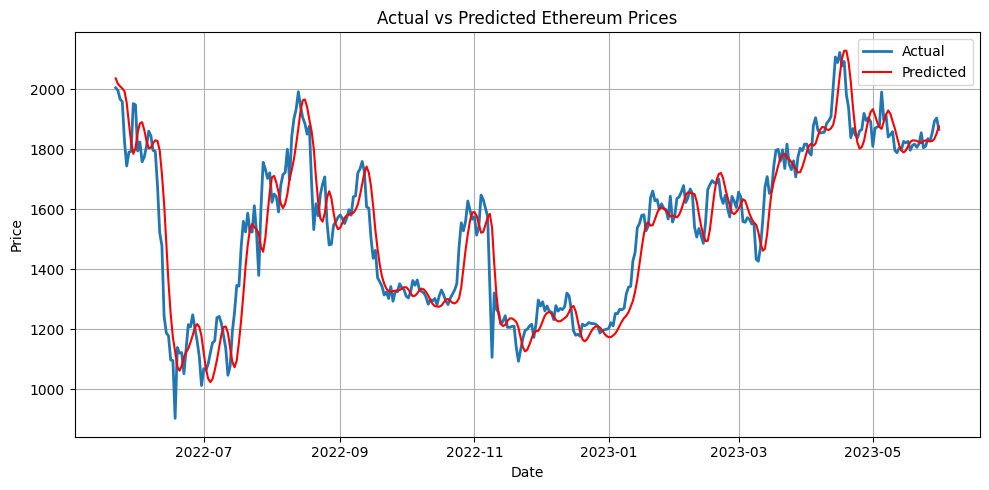

In [ ]:
#----------------------------------------------
# Step 12 - Plot prediction vs. actuals prices
#----------------------------------------------

# Add window size to test idx
start_index = 1482 + 120
# Test set dates range + convert to datetime
dates = data['Date'].iloc[start_index:start_index + len(y_test_orig)].reset_index(drop=True)
dates = pd.to_datetime(dates)

# Plot the actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.plot(dates, y_test_orig, label='Actual', linewidth=2)
plt.plot(dates, y_predict_orig, label='Predicted', color='red')
plt.title('Actual vs Predicted Ethereum Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#--------------------------
# Step 13 - Export results
#--------------------------

# Export prediction dataset
predictions_df = pd.DataFrame({
    'Date': dates,
    'Actual': y_test_orig.flatten(),
    'Predicted': y_predict_orig.flatten()
})

predictions_df.to_csv('ETH_lstm_hmm_predictions.csv', index=False)

from google.colab import files
files.download('ETH_lstm_hmm_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Store metrics in dataframe along with best training/validation loss (record epoch)
results = {
    "seed": 91,
    "best_epoch": best_epoch + 1,    # best validation epoch
    "train_mse": best_train_mse,
    "train_rmse": best_train_rmse,
    "train_mae": best_train_mae,
    "train_mape": best_train_mape,
    "val_mse": best_val_mse,
    "val_rmse": best_val_rmse,
    "val_mae": best_val_mae,
    "val_mape": best_val_mape,
    "test_mse": test_mse,
    "test_rmse": test_rmse,
    "test_mae": test_mae,
    "test_mape": test_mape,
    "test_r2_score": test_r2_score
}

eth_results = pd.DataFrame([results])
eth_results.to_csv('eth_lstm_hmm_results.csv')

files.download('eth_lstm_hmm_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Export results

loss_results = pd.DataFrame(history.history)
loss_results.to_csv('eth_lstm_hmm_loss_results.csv')

files.download('eth_lstm_hmm_loss_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Regime Classification**

In [ ]:
# ------------------------------------------
# Step 1 — Compute Log returns & Volatility
# ------------------------------------------

original = pd.DataFrame({
    'Date': dates,
    'Actual': y_test_orig.ravel()
})

predicted = pd.DataFrame({
    'Date': dates,
    'Predicted': y_predict_orig.ravel()
})

# Compute returns from actual and predicted prices
returns_orig = original['Actual'].pct_change()
returns_pred = predicted['Predicted'].pct_change()
# Drop NaN values from returns
returns_orig = returns_orig.fillna(0)
returns_pred = returns_pred.fillna(0)

# Compute 10-day rolling volatility
volatility_orig = returns_orig.rolling(window=10).std()
volatility_pred = returns_pred.rolling(window=10).std()
volatility_orig = volatility_orig.fillna(0)
volatility_pred = volatility_pred.fillna(0)

# Update dataframes with returns and volatility
original['Returns'] = returns_orig
predicted['Returns'] = returns_pred
original['Volatility'] = volatility_orig
predicted['Volatility'] = volatility_pred


In [ ]:
# --------------------------------
# Step 2 — Label Volatility L-M-H
# --------------------------------

# Compute quantiles as thresholds for low/med/high volatility
low_threshold = volatility_orig.quantile(0.33)   # lower 33%
high_threshold = volatility_orig.quantile(0.67)  # upper 33%

# Label volatility
def label_volatility(vol):
    if vol <= low_threshold:
        return 'low'
    elif vol >= high_threshold:
        return 'high'
    else:
        return 'medium'

# Apply volatility low/medium/high to original and prediction dataset
original['Volatility_level'] = original['Volatility'].apply(label_volatility)
predicted['Volatility_level'] = predicted['Volatility'].apply(label_volatility)


In [ ]:
# -------------------------------
# Step 3 — Regime Classification
# -------------------------------

# Classify regime based on volatility + average sign of the returns
def classify_regime(pred_labels, vol_value, vol_threshold=(low_threshold, high_threshold), window=3):
    regimes = []
    low_threshold, high_threshold = vol_threshold

    for i in range(len(pred_labels) - window):
        window_preds = pred_labels[i:i+window]
        window_vol = vol_value[i+window]
        sign_pred = np.sign(window_preds.mean())

        if window_vol <= low_threshold:
            regimes.append("Neutral")

        else:
            if sign_pred > 0:
                regimes.append("Bull")
            elif sign_pred < 0:
                regimes.append("Bear")
            else:
                regimes.append("Uncertain")

    return regimes

vol_value = original['Volatility']
regimes = classify_regime(original['Returns'], vol_value)


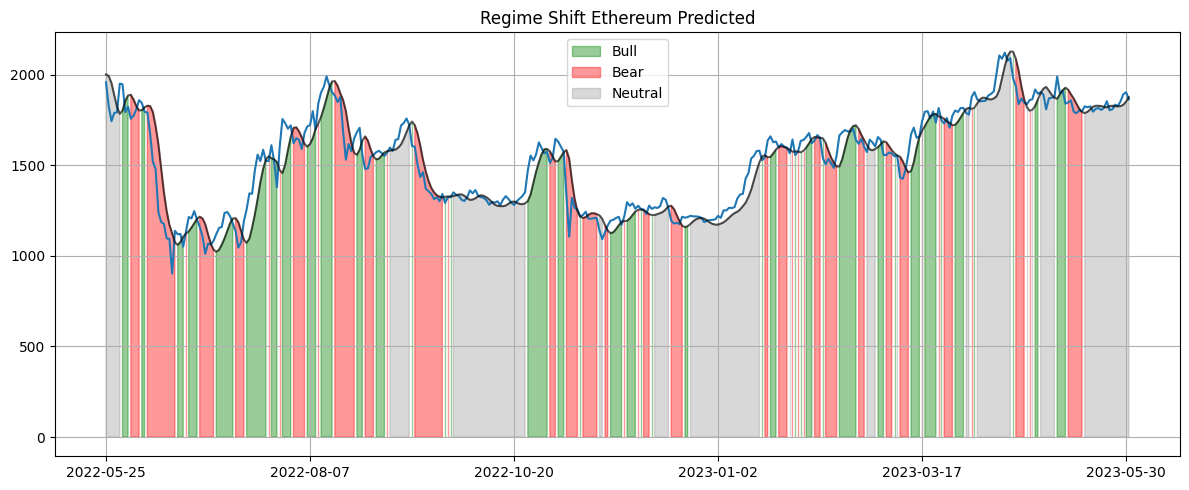

In [ ]:
####################
######  Plots ######
####################

# Plot price vs. date regime shifts in
plt.figure(figsize=(12, 5))
plt.plot(original['Date'][3:], original['Actual'][3:]);
plt.plot(original['Date'][3:], predicted['Predicted'][3:], color='black', alpha=0.65);

plt.fill_between(original['Date'][3:], predicted['Predicted'][3:], where=[r == 'Bull' for r in regimes], color='green', alpha=0.4, label='Bull');
plt.fill_between(original['Date'][3:], predicted['Predicted'][3:], where=[r == 'Bear' for r in regimes], color='red', alpha=0.4, label='Bear');
plt.fill_between(original['Date'][3:], predicted['Predicted'][3:], where=[r == 'Neutral' for r in regimes], color='grey', alpha=0.3, label='Neutral');

N = len(original['Date'][3:]) // 5
xticks = original['Date'][3::N]
plt.xticks(xticks);
plt.legend();
plt.title('Regime Shift Ethereum Predicted')
plt.grid(True);
plt.tight_layout();
plt.show();


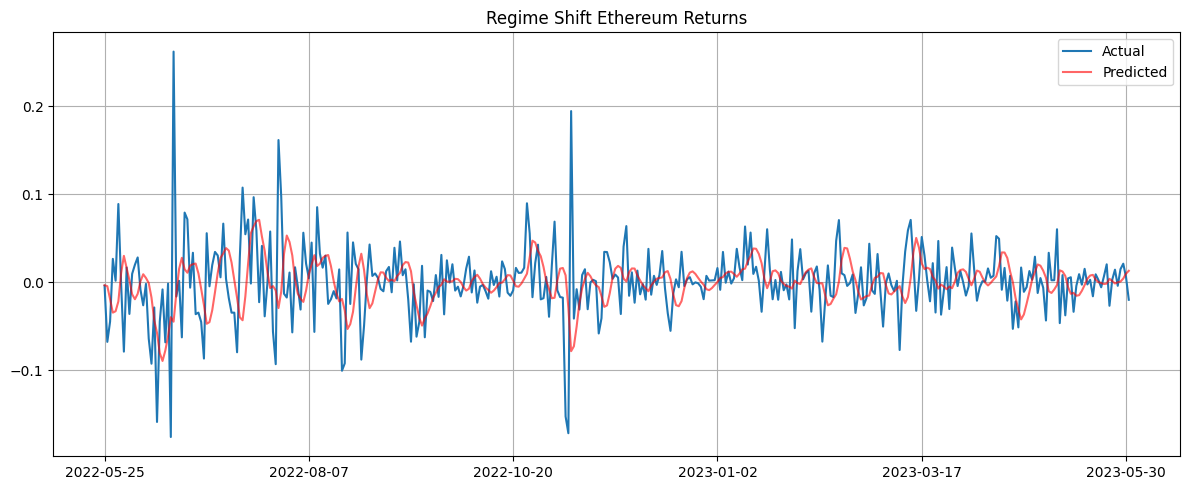

In [ ]:
# Plot regime shift for log returns vs. date
plt.figure(figsize=(12, 5))
plt.plot(original['Date'][3:], original['Returns'][3:], label = 'Actual')
plt.plot(original['Date'][3:], predicted['Returns'][3:], color='red', alpha=0.6, label='Predicted')

N = len(original['Date'][3:]) // 5
xticks = original['Date'][3::N]
plt.xticks(xticks);

plt.legend()
plt.title('Regime Shift Ethereum Returns')
plt.grid(True)
plt.tight_layout()
plt.show()


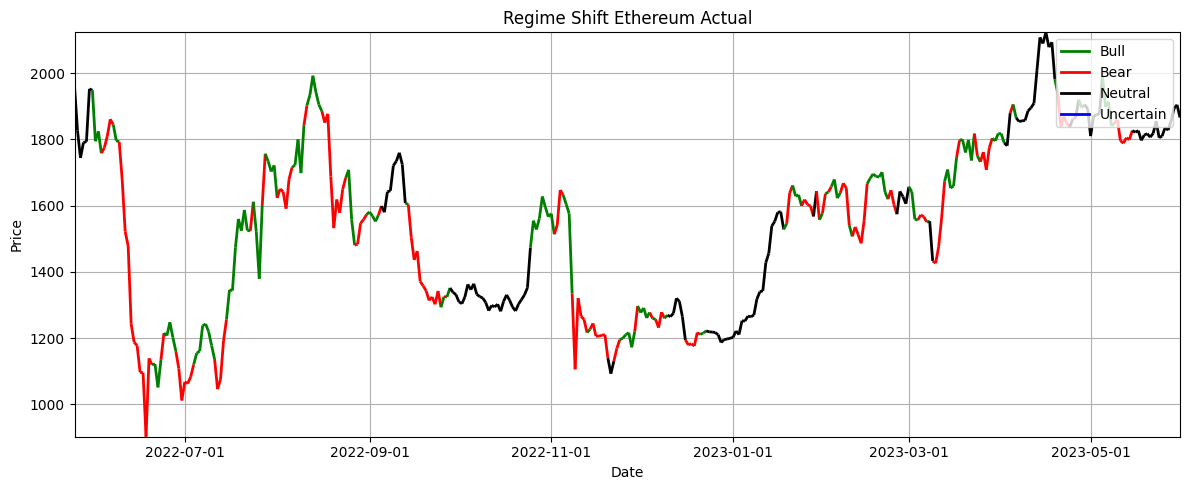

In [ ]:
# Plot price vs. date regime shift
# Select dates, prices values and convert to matplotlib format
# Plot each segment
dates = pd.to_datetime(original['Date'][3:])
prices = original['Actual'][3:].values
x = mdates.date2num(dates)
points = np.array([x, prices]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Map each regime to color & add legend to plot
color_map = {'Bull': 'green', 'Bear': 'red', 'Neutral': 'black', 'Uncertain':'blue'}
colors = [color_map.get(r, 'black') for r in regimes[:len(segments)]]
legend = [
    Line2D([0], [0], color='green', lw=2, label='Bull'),
    Line2D([0], [0], color='red', lw=2, label='Bear'),
    Line2D([0], [0], color='black', lw=2, label='Neutral'),
    Line2D([0], [0], color='blue', lw=2, label='Uncertain')
]


# Plot Lineplot with date range from above/legend
fig, ax = plt.subplots(figsize=(12, 5))
lc = LineCollection(segments, colors=colors, linewidth=2)
ax.add_collection(lc)
ax.set_xlim(x.min(), x.max())
ax.set_ylim(prices.min(), prices.max())
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=0)

ax.legend(handles=legend)
ax.set_title("Regime Shift Ethereum Actual")
ax.set_xlabel("Date")
ax.set_ylabel("Price")

plt.grid(True)
plt.tight_layout()
plt.show()


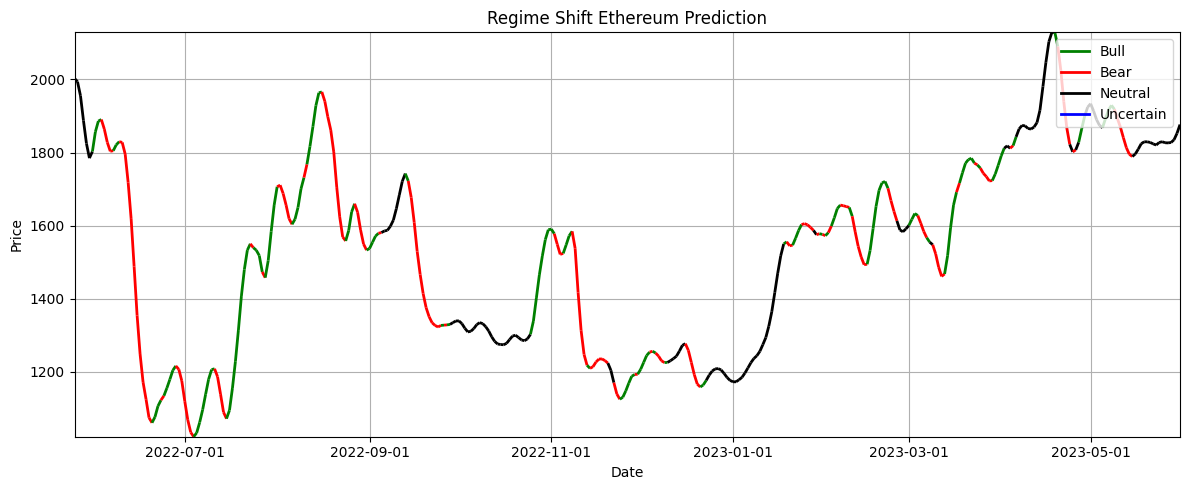

In [ ]:
# Plot price vs. date regime shift

# Select dates, prices values and convert to matplotlib format
# Plot each segment
dates = pd.to_datetime(original['Date'][3:])
prices = predicted['Predicted'][3:].values
x = mdates.date2num(dates)
points = np.array([x, prices]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Map each regime to color & add legend to plot
color_map = {'Bull': 'green', 'Bear': 'red', 'Neutral': 'black', 'Uncertain':'blue'}
colors = [color_map.get(r, 'black') for r in regimes[:len(segments)]]
legend = [
    Line2D([0], [0], color='green', lw=2, label='Bull'),
    Line2D([0], [0], color='red', lw=2, label='Bear'),
    Line2D([0], [0], color='black', lw=2, label='Neutral'),
    Line2D([0], [0], color='blue', lw=2, label='Uncertain')
]


# Plot Lineplot with date range from above/legend
fig, ax = plt.subplots(figsize=(12, 5))
lc = LineCollection(segments, colors=colors, linewidth=2)
ax.add_collection(lc)
ax.set_xlim(x.min(), x.max())
ax.set_ylim(prices.min(), prices.max())
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=0)

ax.legend(handles=legend)
ax.set_title("Regime Shift Ethereum Prediction")
ax.set_xlabel("Date")
ax.set_ylabel("Price")

plt.grid(True)
plt.tight_layout()
plt.show()
